In [11]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [12]:
# Import netket library
import netket as nk

# Import Json, this will be needed to load log files
import json

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

In [13]:
# Define a 1d chain
L = 22
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

In [14]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)

In [15]:
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)

# ED

In [16]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)
exact_gs_energy = evals[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

# Just in case you can't do this calculation, here is the result
# exact_gs_energy = -39.14752260706246

The exact ground-state energy is E0= -39.14752260706284


# Jastrow

In [17]:
import flax.linen as nn
import jax.numpy as jnp
import jax

class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        # sometimes we call this function with a 1D input, sometimes with a 2D.
        # We promote all inputs to 2D to make the following code simpler.
        x = jnp.atleast_2d(x)
        # We vmap along the 0-th axis of the input
        # This will automatically convert a function working on vectors to one working
        # on matrices.
        return jax.vmap(self.evaluate_single, in_axes=(0))(x)
        
    def evaluate_single(self, x):
        # We create the parameter v, which is a vector of length N_sites 
        v_bias = self.param(
            "visible_bias", nn.initializers.normal(), (x.shape[-1],), complex
        )
    
        # The Jastrow matrix is a N_sites x N_sites complex-valued matrix
        J = self.param(
            "kernel", nn.initializers.normal(), (x.shape[-1],x.shape[-1]), complex
        )
        
        # In python @ symbolises matrix multiplication
        return x.T@J@x + jnp.dot(x, v_bias)

In [18]:
ma = Jastrow()
print(ma)

Jastrow()


In [19]:
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.1)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(300, out='Jastrow')
end = time.time()

print('### Jastrow calculation')
print('Has',nk.jax.tree_size(vs.parameters),'parameters')
print('The Jastrow calculation took',end-start,'seconds')

/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/300 [00:00<?, ?it/s]

/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/optimizer/qgt/qgt_onthefly.py:139: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_

### Jastrow calculation
Has 506 parameters
The Jastrow calculation took 37.24373984336853 seconds


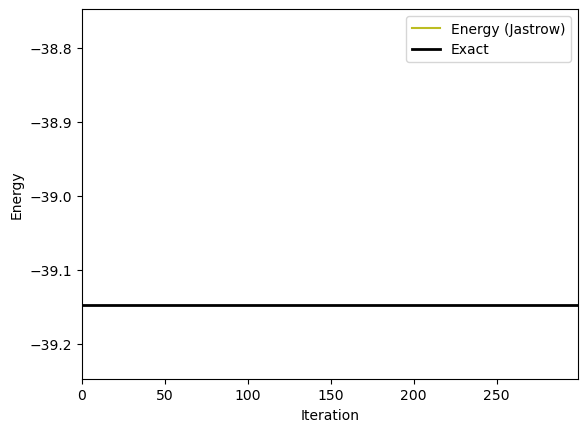

In [20]:
# import the data from log file
data_Jastrow=json.load(open("Jastrow.log"))
   
iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = data_Jastrow["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.4])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

# This is TERRIBLE. The energy is way higher than the ED and doesn't even converge.

# RBM

In [23]:
# RBM ansatz with alpha=1
ma = nk.models.RBM(alpha=1)

In [24]:
# Build the sampler
sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBM', n_iter=600)
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/600 [00:00<?, ?it/s]

### RBM calculation
Has 528 parameters
The RBM calculation took 82.79416584968567 seconds


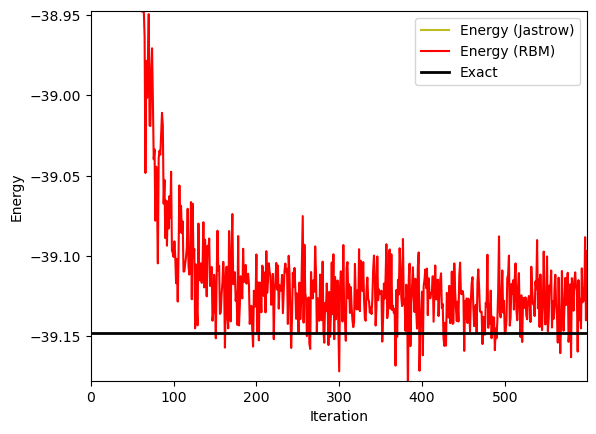

In [25]:
# import the data from log file
data=json.load(open("RBM.log"))
   
# Extract the relevant information
iters_RBM = data["Energy"]["iters"]
energy_RBM = data["Energy"]["Mean"]
    
fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_RBM[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

# RBM with lattice symmetries

In [26]:
## Symmetric RBM Spin Machine
ma = nk.models.RBMSymm(symmetries=g.translation_group(), alpha=1)

# Metropolis Exchange Sampling
# Notice that this sampler exchanges two neighboring sites
# thus preservers the total magnetization
sa = nk.sampler.MetropolisExchange(hi, graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1000)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(out='RBMSymmetric', n_iter=300)
end = time.time()

print('### Symmetric RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The Symmetric RBM calculation took',end-start,'seconds')

/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/300 [00:00<?, ?it/s]

### Symmetric RBM calculation
Has 24 parameters
The Symmetric RBM calculation took 42.70922493934631 seconds


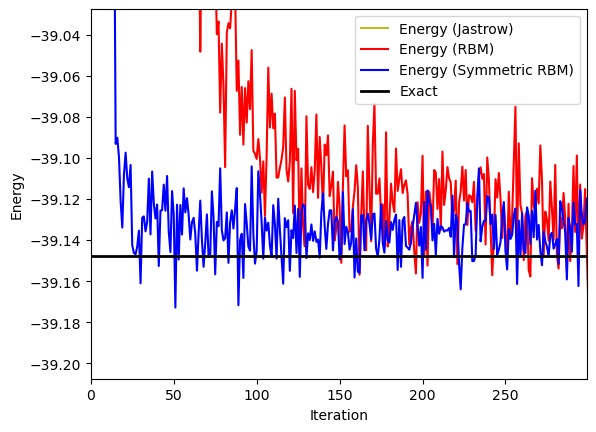

In [27]:
## import the data from log file
data=json.load(open("RBMSymmetric.log"))

# Extract the relevant information
iters_symRBM = data["Energy"]["iters"]
energy_symRBM = data["Energy"]["Mean"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.plot(iters_RBM, energy_RBM, color='red', label='Energy (RBM)')
ax1.plot(iters_symRBM, energy_symRBM, color='blue', label='Energy (Symmetric RBM)')

ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
if exact_gs_energy:
    plt.axis([0,iters_symRBM[-1],exact_gs_energy-0.06,exact_gs_energy+0.12])
    plt.axhline(y=exact_gs_energy, xmin=0,
                    xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

# Learning with feed forward NN

In [28]:
class Model(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*x.shape[-1], param_dtype=np.complex128, kernel_init=nn.initializers.normal(stddev=0.1), bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        return jax.numpy.sum(x, axis=-1)
    
ffnn = Model()

sa = nk.sampler.MetropolisExchange(hi, graph=g)

# The variational state
vs = nk.vqs.MCState(sa, ffnn, n_samples=1000)

opt = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)


start = time.time()
gs.run(out='FF', n_iter=300)
end = time.time()

print('### Feed Forward calculation')
print('Has',vs.n_parameters,'parameters')
print('The Feed Forward calculation took',end-start,'seconds')

/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


  0%|          | 0/300 [00:00<?, ?it/s]

/Users/wttai/miniconda3/envs/netket/lib/python3.12/site-packages/netket/optimizer/qgt/qgt_onthefly.py:139: HolomorphicUndeclaredWarning: 
Defaulting to `holomorphic=False`, but this might lead to increased
computational cost or disabled features. Check if your variational
function is holomorphic, and if so specify `holomorphic=True`as an extra
keyword argument.

To silence this warning, specify the `holomorphic=False/True` keyword
argument.

To numerically check whether your variational function is or not holomorphic
you can use the following snippet:

```python
   vs = nk.vqs.MCState(...)

   nk.utils.is_probably_holomorphic(vs._apply_fun, vs.parameters, vs.samples, vs.model_state)
```

if `nk.utils.is_probably_holomorphic` returns False, then your function is not holomorphic.
If it returns True, it is probably holomorphic.


-------------------------------------------------------
For more detailed informations, visit the following link:
	 https://netket.readthedocs.io/en/latest/api/_

### Feed Forward calculation
Has 1012 parameters
The Feed Forward calculation took 136.645033121109 seconds


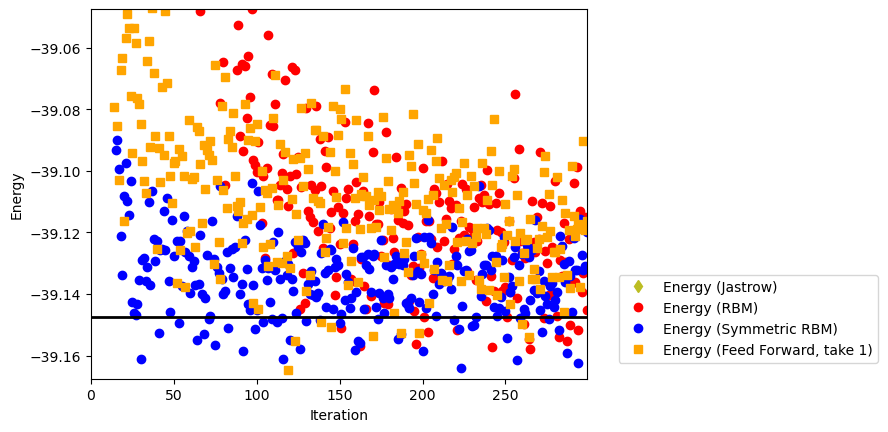

In [29]:
# import the data from log file
data=json.load(open("FF.log"))

# Extract the relevant information
iters_FF = data["Energy"]["iters"]
energy_FF = data["Energy"]["Mean"]["real"]

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8',linestyle="None", marker='d',label='Energy (Jastrow)')
ax1.plot(iters_RBM, energy_RBM, color='red', marker='o',linestyle="None",label='Energy (RBM)')
ax1.plot(iters_symRBM, energy_symRBM, color='blue',linestyle="None",marker='o',label='Energy (Symmetric RBM)')
ax1.plot(iters_FF, energy_FF, color='orange', marker='s',linestyle="None",label='Energy (Feed Forward, take 1)')
ax1.legend(bbox_to_anchor=(1.05, 0.3))
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_FF[-1],exact_gs_energy-0.02,exact_gs_energy+0.1])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_RBM[-1], linewidth=2, color='k', label='Exact')
plt.show()